# Zadanie 3

## Rozkłady $\alpha$-stabline

In [56]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest, norm, cauchy
from scipy.stats.mstats import normaltest

plt.style.use('ggplot')

In [21]:
def generation(x_vector, a_vector, p_vector, m, value=1):
    if value == 1:
        x_n = x_vector[0]
        for i in range(1, len(x_vector) - 1):
            x_n += a_vector[i]*x_vector[i]**p_vector[i]
        return int(x_n % m)
    result = []
    for _ in range(value):
        x_n = x_vector[0]
        for i in range(1, len(x_vector) - 1):
            x_n += a_vector[i]*x_vector[i]**p_vector[i]
        x_n = int(x_n % m)
        result.append(x_n)
        for i in range(len(x_vector)-1):
            x_vector[i] = x_vector[i+1]
        x_vector[-1] = x_n
    
    return result

In [22]:
def uniform_generator(a=0, b=1, value=1):
    out = []
    m = 1/(5**(-303))
    a_vector = [m*2**87, m*3**64, m*5**76]
    p_vector = [0.05738, 1.5646, 1.23456]
    for _ in range(value):
        x_n = [time.clock()%400, time.clock() % 400, time.time()]
        if value == 1:
            return a + generation(x_n, a_vector, p_vector, m)/(m-1)*(b-a)
        out.append(a + generation(x_n, a_vector, p_vector, m)/(m-1)*(b-a))
    return out

In [23]:
def alfaStabilny(alfa, beta, mu, sigma):
    """Funkcja generująca liczby z rozkładu alfa-stabilnego. """
    U = uniform_generator(-math.pi/2, math.pi/2)
    E = -math.log(uniform_generator())
    if alfa != 1:
        S = (1+(beta**2)*(math.tan(math.pi*alfa/2))**2)**(1/(2*alfa))
        B = math.atan(beta*math.tan(math.pi*alfa/2))/alfa
        A = (S*math.sin(alfa*(U+B)))/((math.cos(U))**(1/alfa))
        C = (math.cos(U-alfa*(U+B))/E)**((1-alfa)/alfa)
        X = A*C
        return sigma*X + mu
    else:
        A = (math.pi/2 + beta * U)*math.tan(U)
        L = ((math.pi/2) * E * math.cos(U))/((math.pi/2) + beta*U)
        B = beta*math.log(L)
        X = (2/math.pi)*(A - B)
        return sigma*X + (2/math.pi) * beta * sigma * math.log(sigma) + mu

In [24]:
def cummulativeDistribution(data, x):
    """ Counts value of empirical cummulative distribution of x. """
    return sum([1 for element in data if element < x])/len(data)

def plotECDF(data):
    dataToPlot = []
    n = len(data)
    zakres = np.linspace(1.1*min(data), 1.1*max(data), n)
    for i in zakres:
        temp = cummulativeDistribution(data, i)
        dataToPlot.append(temp)
    
    plt.scatter(zakres[1:-1], dataToPlot[:-2], s = 10, facecolors='none', edgecolors='k')
    # Wycinki wynikają z przesunięcia punktów oraz braku otwartego kółka na końcu.
    for i in range(len(dataToPlot) - 1):
        x = [zakres[i], zakres[i+1]]
        y = [dataToPlot[i], dataToPlot[i]]
        plt.plot(x,y, color = 'k')
    plt.plot(zakres[-1], dataToPlot[-1])

In [67]:
def analysisStableData(alfa, t = 1000):
    data = [alfaStabilny(alfa, 0, 0, 1) for _ in range(t)]
    
    plt.figure(figsize = (16,6))
    
    plt.subplot(1,2,1)
    plt.title('ECDF of $S({},0,0,1)$'.format(alfa))
    plotECDF(data)
    
    plt.subplot(1,2,2)
    plt.hist(data, density = True)
    plt.show()

In [63]:
def testujRozklad(data, rozklad):
    alfa = 0.05
    if rozklad == 'cauchy':
        score = kstest(data, rozklad)
    elif rozklad == 'norm':
        score = normaltest(data)
    else:
        raise ValueError('Nie mamy testu dla takiego rozkładu.')
    pvalue = score[1]
    return pvalue >= alfa

def testuj(args, rozklad, n = 1000, MCS = 1000):
    score = 0
    for _ in range(MCS):
        data = [alfaStabilny(*args) for _ in range(n)]
        wynikTestu = testujRozklad(data, rozklad)
        if wynikTestu:
            score += 1
    return score/MCS

# 1. Wstęp teoretyczny

W zagadnieniach związanych z probablisityką oraz statystyką często mamy do czynienia, nie z jedną zmienną losową, ale z wieloma zmiennymi losowymi. W szczególności dla zastosowań statystycznych często konstruujemy statystykę $T(X_1,\dots,X_n)$, która zawiera w sobie sumę zmiennych losowych, a następnie wyznaczamy jej rozkład. W tym momencie spotykamy się z problemem jaki rozkład ma ciąg zmiennych losowych postaci $\sum_{i=0}^{n}X_i$. W tym momencie z pomocą przychodzi nam teoria prawdopodobieństwa, która mówi w następujący sposób:

Rozważmy ciąg $X_1,X_2,\dots$ zmiennych losowych, ciąg stałych dodatnich $\{a_n\}_{n=1}^{\infty}$ oraz ciąg stałych rzeczywistych $\{b_n\}_{n=1}^{\infty}$ taki, że:

$$ \frac{X_1 + \dots + X_n - b_n}{a_n} \xrightarrow[d]{n\to\infty} Y $$

Dodatkowo, jeżeli założymy, że:
1. $X_i$ - ciąg niezależny zmiennych, to $Y$ ma rozkład nieskończenie stabilny
2. $X_i$ - ciąg niezależnych zmiennych o tym samym rozkładzie, to $Y$ ma rozkład stabilny
3. $X_i$ - ciąg niezależnych zmiennych o tym samym rozkładzie oraz $EX_i^2 < \infty$, to $Y$ ma rozkład normalny

Stąd możemy zauważyć, że rozkład normalny jest podzbiorem rozkładów stabilnych, natomiast rozkład stabilny jest podzbiorem rozkładów nieskończenie podzielnych.

Znając powyższą klasyfikację dochodzimy do wniosku, że rozkłady stabilne są bardzo ważną klasą rozkładów probabilsitycznych o szerokich zastosowaniach praktycznych. Wprowadźmy zatem równoważną definicję rozkładu stabilnego, która wprowadzi nam oznaczenia używane w dalszej części zadania.

**Definicja.** Zmienna losowa X ma rozkład stabilny, jeżeli jej funkcja charakterystyczna ma postać:

Dla $\alpha \neq 1 $:
$$ \varphi_X(t) = exp(-\sigma^\alpha|t|^\alpha(1-i\beta sgn(t) tg(\frac{\pi\alpha}{2})) + i\mu t)$$

Dla $\alpha = 1 $:
$$ \varphi_X(t) = exp(-\sigma|t|(1-i\beta \frac{2}{\pi} sgn(t) ln|t|) + i\mu t),$$

gdzie:
- $\alpha\in (0,2]$ - indeks stabliności,
- $\beta\in [-1,1]$ - parametr skośności,
- $\sigma > 0$ - parametr skali,
- $\mu \in \mathbb{R}$ - przesunięcie.

Przyjmijmy także oznaczenie: $X \sim S(\alpha,\beta,\mu,\sigma)$

**Fakt.** Dla $\alpha=2, \beta=0$ otrzymujemy rozkład normalny o parametrach $\mu$, $\sigma$ oraz dla $\alpha = 1, \beta = 0$ otrzymujemy rozkład Cauchy'ego z parametrami $\mu$, $\sigma$.

Ponadto w celu przetestowania próbek wykorzystamy dwa testy statystyczne, które krótko opiszemy.

**Test Kołmogorova-Smirnova**

Jest to test oparty na znalezieniiu odległości supremum różnicy dystrubanty empirycznej od dystrybuanty teoretycznej, tzn.szukamy $D_n= \sup_x |F_n(x)-F(x)|$. Pod hipotezą zerową, że próbka pochodzi z danego rozkładu otrzymujemy, że $\sqrt{n}D_n\xrightarrow[d]{n\to\infty}\sup_t |B(F(t))|$, gdzie $B(t)$ jest mostem Browna.

Test Kołmogorova-Smirnova jest skonstruowany na podstawie wartości krytycznej rozkładu Kołmogorova. Hipoteza zerowa jest odrzucona na poziomie istotności $\alpha$, jeżeli:
$$\sqrt{n}D_n>K_\alpha,\,$$
gdzie $K_\alpha$ to kwantyl rzędu alfa rozkładu Kołomogorova.

Na podstawie:
- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html
- http://smarterpoland.pl/index.php/2013/04/wybrane-testy-normalnoci/
- https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

**Test normalności Normaltest**

Normaltest z pythonowej biblioteki $SciPy$ jest to implementacja testu Omnibus. Test ten ma postać:
$$ K^2 = Z_1^2(g_1) + Z_2^2(g_2)\, $$
gdzie 
- $Z_1(g_1)$ to pewna transformacja próbkowej wartości skośności,
- $Z_2(g_2)$ to pewna transformacja próbkowej wartości kurtozy.

Jeżeli hipoteza zerowa o rozkładzie normalnym jest prawdziwa, to $K^2$ ma w przybliżeniu rozkład $\chi^2$ z 2 stopniami swobody.

Na podstawie:
- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.normaltest.html#scipy.stats.normaltest
- https://en.wikipedia.org/wiki/D%27Agostino%27s_K-squared_test

# 2. Problem badawczy
W poniższym zadaniu będziemy chcieli stworzyć generator liczb pseudolosowych z dowolnego rozkładu stabilnego. W tym celu będziemy chcieli wyrysować dystrybuanty empiryczne oraz histogramy tych rozkładów dla $\alpha \in \{\frac{1}{2},1, \frac{3}{2}, 2\}$, a następnie wiedząc, że dla odpowiednich parametrów otrzymujemy znane rozkłady prawdopodobieństwa, przetestujemy je za pomocą testów statystycznych. 

# 3. Rozwiązanie

W rozwiązaniu posłużymy się pseudokodem zaproponowanym przez R.Werona, który jest przytoczony w treści zadania. Pseudokod pochodzi z "Stable distributions" S.Borak, W.Härdle, R.Weron - Statistical tools for finance and insurance, 2005.

W celach badawczych wyrysujemy dystrybuanty empiryczne oraz histogramy rozkładów stabilne postaci $S(\alpha,0,0,1)$, gdzie $\alpha \in \{\frac{1}{2},1, \frac{3}{2}, 2\}$.


W celu przetestowania poprawności rozkładu wykonamy 1000-krotnie KS-Test dla próbki długości 1000 z rozkładu $S(1,0,0,1)$, aby sprawdzić czy jest to faktycznie rozklad Cauchy'ego(0,1) oraz analogicznie NormalTest dla próbki długości 1000 z rozkładu $S(2,0,0,1)$, czy jest to faktycznie rozkład Normalny(0,1). Testy zostaną przeprowadzone na poziomie istotności $\alpha=0.05$.

# 4. Wyniki

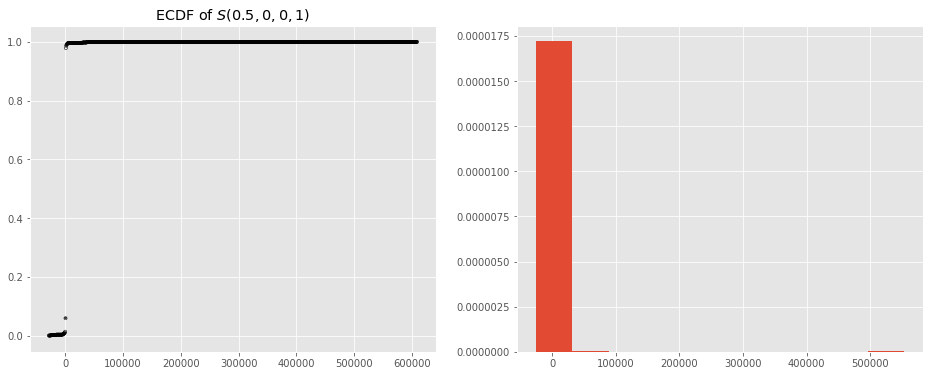

In [68]:
analysisStableData(1/2)

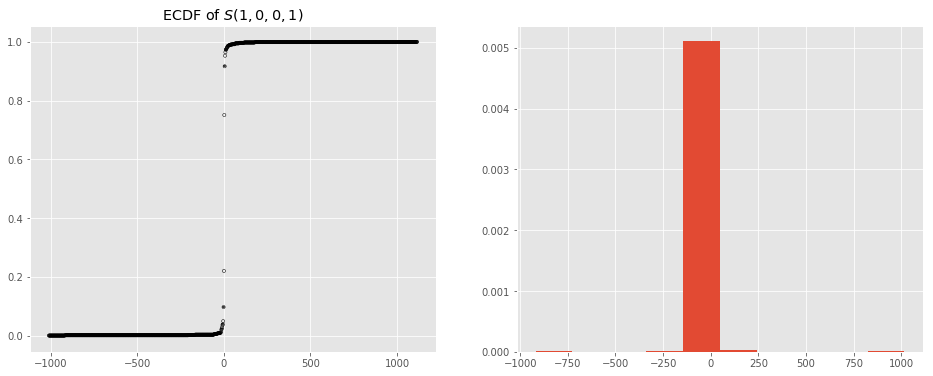

In [70]:
analysisStableData(1)

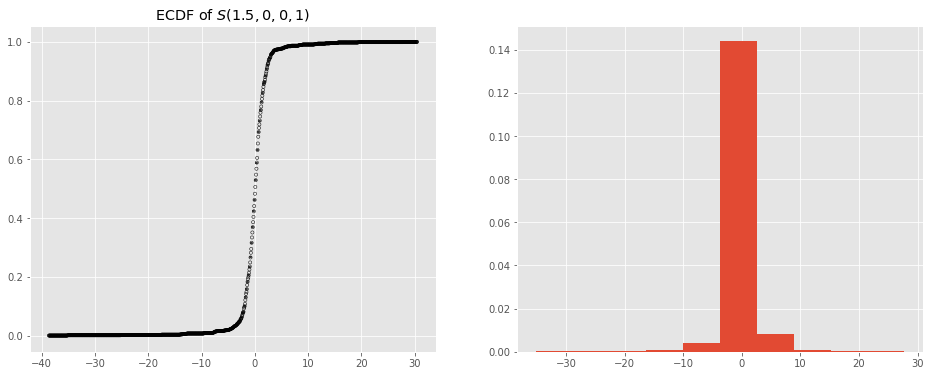

In [71]:
analysisStableData(3/2)

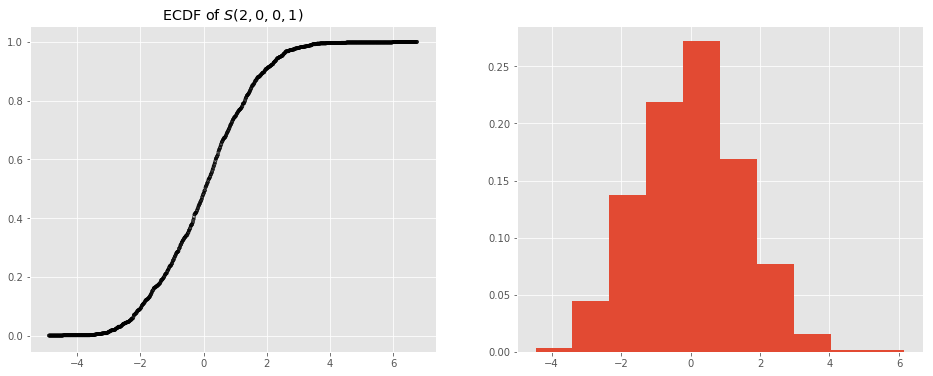

In [72]:
analysisStableData(2)

In [73]:
testuj((2,0,0,1), 'norm')

0.938

In [74]:
testuj((1,0,0,1), 'cauchy')

0.946

Z przeprowadzonych powżyej testów wynika, że w ok. 95% przypadków nasza próbka przechodzi odpowiedni test, więc możemy uznać, że nasz generator liczb pseudolosowych z rozkładu stabilnego jest poprawny.